In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular
from tqdm import tqdm

In [2]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
import os
files = os.listdir("dataset")

import csv

class Route:
    def __init__(self, phi, v, M):
        self.phi = phi
        self.v = v
        self.M = M
    def __len__(self):
        return len(self.phi)
    
routes = []

allRows = 0

maxAngle = 0
maxSpeed = 0
maxTorque = 0

for file in files:
    path = os.path.join("dataset", file)
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        phi = []
        v = []
        M = []
        for row in spamreader:
            phi.append(float(row[1]))
            v.append(float(row[2]))
            M.append(float(row[3]))

            maxAngle = max(abs(float(row[1])), maxAngle)
            maxSpeed = max(abs(float(row[2])), maxSpeed)
            maxTorque = max(abs(float(row[3])), maxTorque)
        routes.append(Route(torch.tensor(phi), torch.tensor(v), torch.tensor(M)))
        allRows += len(phi)


print(allRows)
print(maxAngle, maxSpeed, maxTorque)

673988
41.70000076293945 39.09857177734375 1.0


Now we have everything stored in routes. Time to generate some test data

In [4]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

prev_data = 300
fwd_data = 100

input_length = 3 * prev_data + fwd_data

all_routes = len(routes)
train_routes = routes[0:12]
test_routes = routes[12:14]

group = 1

def caddy_dataset(train):
    i_data = []
    o_data = []
    routes = train_routes if train else test_routes
    for route in tqdm(routes):
        for idx in range(prev_data, len(route.v)-fwd_data+1, 4):
            phi = route.phi[idx-prev_data : idx]/maxAngle
            v = route.v[idx-prev_data : idx]/maxSpeed
            M = route.M[idx-prev_data : idx+fwd_data]/maxTorque
            
            phi = phi.reshape(-1, group).mean(axis=1)
            v = v.reshape(-1, group).mean(axis=1)
            M = M.reshape(-1, group).mean(axis=1)
            
            o = route.phi[idx+fwd_data-1 : idx+fwd_data]/maxAngle

            data_input = np.concatenate((phi, v, M))
            i_data.append(data_input)
            o_data.append(o)
    return SimDataset(len(i_data), i_data, o_data)


train_set = caddy_dataset(True)
test_set = caddy_dataset(False)

print(len(train_set), len(test_set))

100%|██████████| 2/2 [00:00<00:00, 20.40it/s]

20202 988


(1000,)


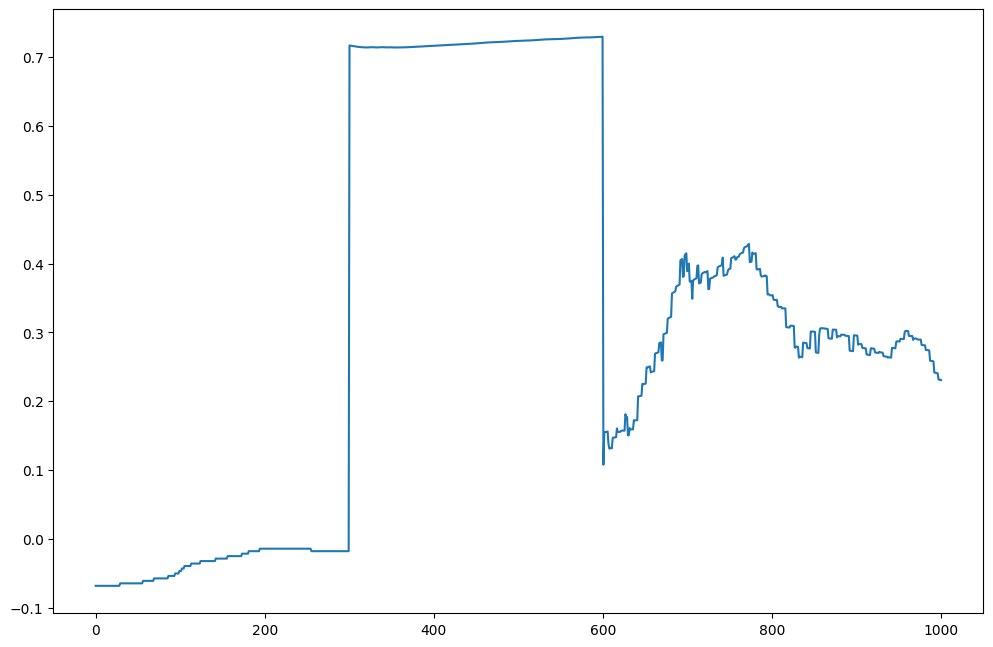

In [5]:
t0 = train_set[0][0]
print(t0.shape)
plt.plot(np.linspace(0, input_length//group, input_length//group), t0)

In [6]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False)
print(len(train_dataloader))
print(len(test_dataloader))

315
16


In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_length//group, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


In [8]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if debug:
        loss = loss.item()*100
        print(f"Train loss: {loss}")
    return loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()*100

    test_loss /= num_batches
    print(f"Test  loss: {test_loss} \n")
    return test_loss

model = NeuralNetwork()
for p in model.parameters():
    print(p.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

torch.Size([64, 1000])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
82817


Epoch 0
Train loss: 1.7905589193105698
Test  loss: 2.2376053137122653 

Epoch 1
Train loss: 0.25024262722581625
Test  loss: 2.1154837111680536 

Epoch 2
Train loss: 0.21023680455982685
Test  loss: 2.247908250319597 

Epoch 3
Train loss: 0.07582643302157521
Test  loss: 1.7785054915293586 

Epoch 4
Train loss: 0.12347566662356257
Test  loss: 1.2211989454954164 

Epoch 5
Train loss: 0.09275635238736868
Test  loss: 0.819035507083754 

Epoch 6
Train loss: 0.12463900493457913
Test  loss: 0.6236754725250648 

Epoch 7
Train loss: 0.08634472033008933
Test  loss: 0.509261867046007 

Epoch 8
Train loss: 0.10440193582326174
Test  loss: 0.4251341237250017 

Epoch 9
Train loss: 0.07419483736157417
Test  loss: 0.3802104511123616 

Epoch 10
Train loss: 0.05527156754396856
Test  loss: 0.3235622256397619 

Epoch 11
Train loss: 0.0626482767984271
Test  loss: 0.304704358404706 

Epoch 12
Train loss: 0.05240052123554051
Test  loss: 0.3007584147781017 

Epoch 13
Train loss: 0.0604151573497802
Test  loss: 0.

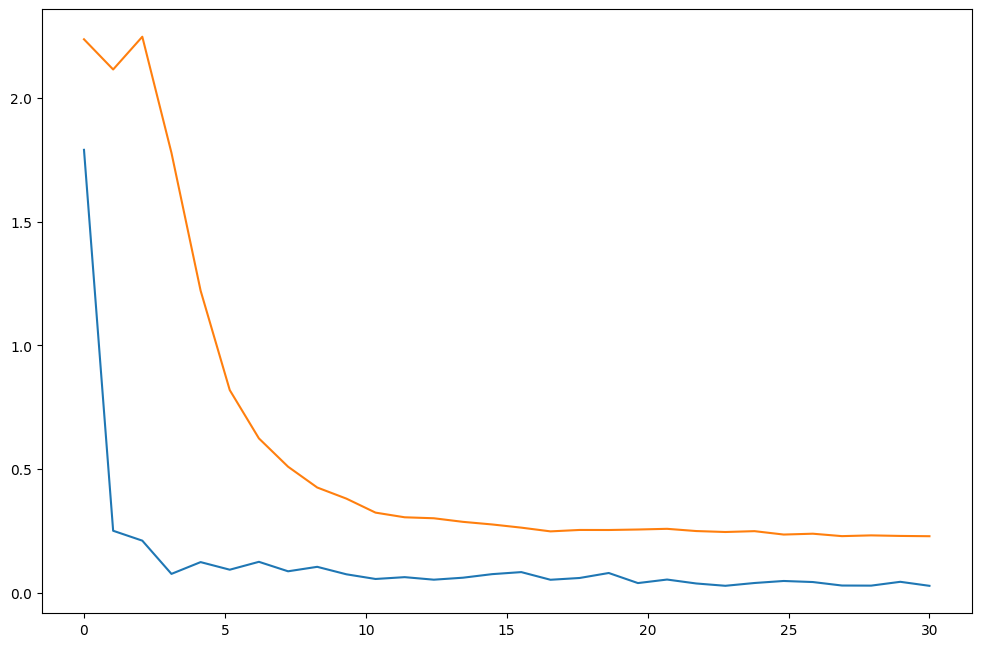

In [9]:
epochs = 30
skip = 1
loss_t = []
loss_e = []
for t in range(epochs):
    if t%skip == 0:
        print(f"Epoch {t}")
    loss_t.append(train_loop(train_dataloader, model, loss_fn, optimizer, t%skip==0))
    if t%skip == 0:
        loss_e.append(test_loop(test_dataloader, model, loss_fn))

plt.plot(np.linspace(0, epochs, epochs), loss_t)
plt.plot(np.linspace(0, epochs, epochs), loss_e)

In [21]:
random_sample = test_set[randrange(len(test_set))]
print(random_sample[0][599]*maxAngle, "initial angle")
print(random_sample[1]*maxAngle)

torch_data_input = torch.from_numpy(random_sample[0])
print(model(torch_data_input).item()*maxAngle)

34.150503837028054 initial angle
tensor([-7.2000])
-8.124606278174156


In [11]:
random_sample = test_set[randrange(len(test_set))]

-0.2714
2.4000000986719527 initial angle
tensor([4.2000])
1.1238317916894047


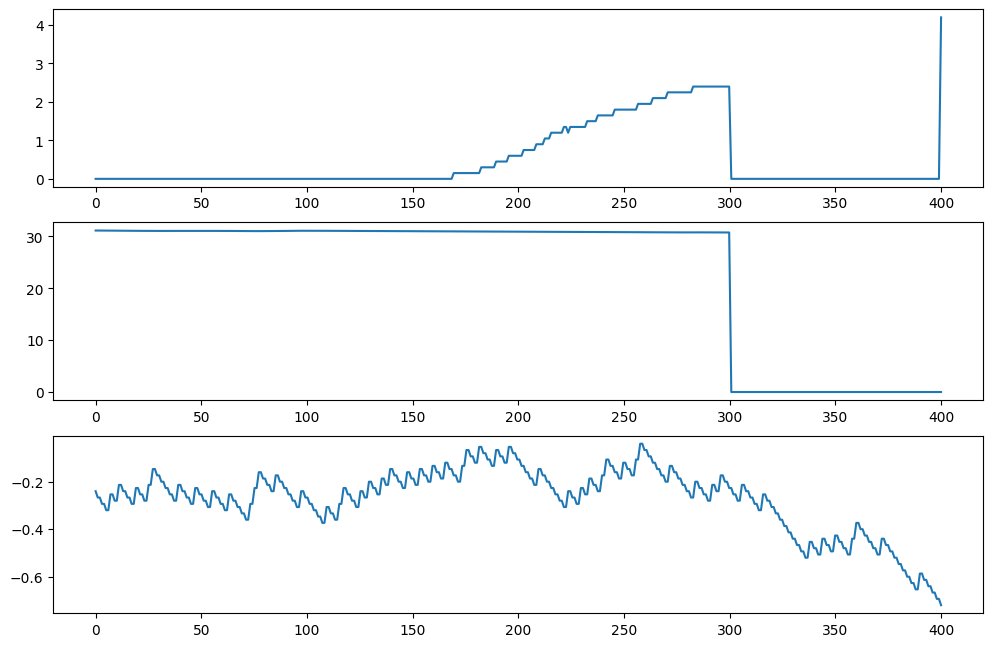

In [12]:
i = random_sample[0]
# for j in range(900, 1000):
#     i[j]=1

phi = i[0:300]*maxAngle
v = i[300:600]*maxSpeed
M = i[600:1000]*maxTorque

print(np.average(i[600:1000]))
v.resize(400)
phi.resize(400)
phi[-1] = random_sample[1][0]*maxAngle

time = 400
_, axs = plt.subplots(3)
axs[0].plot(np.linspace(0, time, time), phi)
axs[1].plot(np.linspace(0, time, time), v)
axs[2].plot(np.linspace(0, time, time), M)

print(random_sample[0][299]*maxAngle, "initial angle")
print(random_sample[1]*maxAngle)

torch_data_input = torch.from_numpy(random_sample[0])
print(model(torch_data_input).item()*maxAngle)

In [13]:
torch.save(model, 'model.pth')

In [14]:
model = torch.load('model.pth')
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1000, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=1, bias=True)
    (13): Tanh()
  )
)
